In [39]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Генерация данных
np.random.seed(42)
X_train = np.random.rand(1000, 5) * 10
y_train = 2 * X_train[:, 0] + 3 * X_train[:, 1] + np.random.normal(0, 1, 1000)

X_test = np.random.rand(200, 5) * 10
y_test = 2 * X_test[:, 0] + 3 * X_test[:, 1] + np.random.normal(0, 1, 200)

# 2. Обучение CatBoost с одним деревом
cat_model = CatBoostRegressor(
    iterations=1,  # Только одно дерево!
    depth=3,
    verbose=0
)
cat_model.fit(X_train, y_train)



In [49]:
# 3. Получение индексов листьев (теперь будет 1000 значений)
train_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_train, y_train)).flatten()
test_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_test)).flatten()

print(f"Train leaf indices shape: {train_leaf_indices.shape}")  # Должно быть (1000,)

# 4. Сбор статистик по листьям
leaf_stats = []
for leaf in np.unique(train_leaf_indices):
    mask = train_leaf_indices == leaf
    stats = {
        'leaf': leaf,
        'mean_target': np.mean(y_train[mask]),
        'mean_feature_0': np.mean(X_train[mask, 0]),
        'mean_feature_1': np.mean(X_train[mask, 1]),
        'mean_feature_2': np.mean(X_train[mask, 2]),
        'mean_feature_3': np.mean(X_train[mask, 3]),
        'mean_feature_4': np.mean(X_train[mask, 4]),
        'n_samples': np.sum(mask),
    }
    leaf_stats.append(stats)

leaf_stats_df = pd.DataFrame(leaf_stats)



Train leaf indices shape: (1000,)


In [50]:
leaf_stats_df

,leaf,mean_target,mean_feature_0,mean_feature_1,mean_feature_2,mean_feature_3,mean_feature_4,n_samples
0,0,12.900817,3.875832,1.733186,4.919095,4.994874,4.723027,281
1,1,23.633672,3.715625,5.421846,4.699635,4.826793,5.117173,260
2,2,23.263814,8.893280,1.761219,4.964224,5.016133,5.646535,90
3,3,34.186297,8.865991,5.468064,4.829285,4.810160,5.361096,75
4,5,33.143875,3.699811,8.640388,5.000113,5.126025,4.987717,224
5,7,43.233117,8.777782,8.572662,5.220030,5.129270,4.504011,70


In [51]:
# 5. Кластеризация листьев
kmeans = KMeans(n_clusters=3, random_state=42)
leaf_stats_df['cluster'] = kmeans.fit_predict(leaf_stats_df[['mean_target', 'mean_feature_0']])

# 6. Сопоставление кластеров
train_data = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(5)])
train_data['target'] = y_train
train_data['leaf'] = train_leaf_indices
train_data = train_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf')


In [52]:
# 7. Обучение линейных моделей
linear_models = {}
for cluster in leaf_stats_df['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster]
    X_cluster = cluster_data[[f'feature_{i}' for i in range(5)]].values
    y_cluster = cluster_data['target'].values
    
    lr = LinearRegression()
    lr.fit(X_cluster, y_cluster)
    linear_models[cluster] = lr



In [53]:
# 8. Предсказание на тесте
test_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(5)])
test_data['leaf'] = test_leaf_indices
test_data = test_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf', how='left')

# Заполняем пропущенные кластеры (новые листья)
test_data['cluster'] = test_data['cluster'].fillna(-1)

test_predictions = np.zeros(len(X_test))
for cluster in linear_models:
    mask = test_data['cluster'] == cluster
    test_predictions[mask] = linear_models[cluster].predict(X_test[mask])

# Для новых листьев используем предсказание CatBoost
new_leaf_mask = test_data['cluster'] == -1
if new_leaf_mask.any():
    test_predictions[new_leaf_mask] = cat_model.predict(X_test[new_leaf_mask])

# Оценка качества
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_predictions)))
print("Test MAPE:", np.sqrt(mean_absolute_percentage_error(y_test, test_predictions)))

Test RMSE: 1.0812479274250786
Test MAPE: 0.20924418567472164


In [46]:
import seaborn as sns

<Axes: xlabel='target', ylabel='Count'>

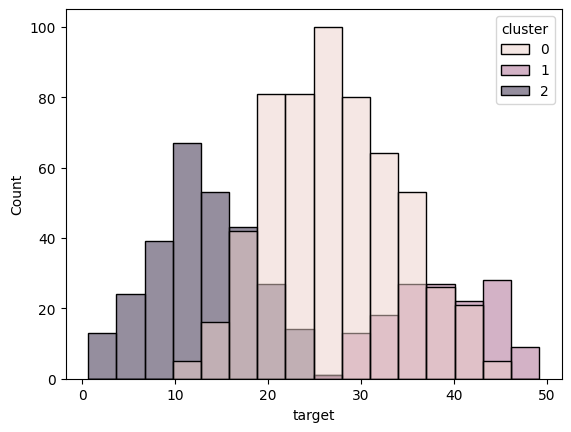

In [48]:
sns.histplot(train_data, x = 'target', hue='cluster')

In [62]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# 1. Генерация данных
np.random.seed(42)
n_features = 5
X_train = np.random.rand(1000, n_features) * 10
y_train = 2*X_train[:, 0] + 3*X_train[:, 1] + np.random.normal(0, 1, 1000)

X_test = np.random.rand(200, n_features) * 10
y_test = 2*X_test[:, 0] + 3*X_test[:, 1] + np.random.normal(0, 1, 200)

# 2. Обучение CatBoost (используем только 1 дерево для простоты)
cat_model = CatBoostRegressor(
    iterations=1,  # Одно дерево для избежания проблем с размерностями
    depth=3,
    verbose=0
)
cat_model.fit(X_train, y_train)

# 3. Получение индексов листьев
train_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_train, y_train)).flatten()
test_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_test)).flatten()

# 4. Сбор статистики по листьям (правильная индексация)
def get_leaf_stats(leaf_indices, X, y):
    """Собирает статистики по листьям с правильной индексацией"""
    stats_list = []
    for leaf in np.unique(leaf_indices):
        mask = leaf_indices == leaf
        stat = {
            'leaf': leaf,
            'n_samples': np.sum(mask),
            'target_mean': np.mean(y[mask]),
            'target_std': np.std(y[mask])
        }
        
        # Добавляем статистики по всем признакам
        for i in range(X.shape[1]):
            stat[f'feature_{i}_mean'] = np.mean(X[mask, i])
            stat[f'feature_{i}_std'] = np.std(X[mask, i])
        
        stats_list.append(stat)
    
    return pd.DataFrame(stats_list)

leaf_stats_df = get_leaf_stats(train_leaf_indices, X_train, y_train)

# 5. Кластеризация листьев
cluster_features = [col for col in leaf_stats_df.columns 
                   if col.startswith(('target_', 'feature_'))]
kmeans = KMeans(n_clusters=3, random_state=42)
leaf_stats_df['cluster'] = kmeans.fit_predict(leaf_stats_df[cluster_features])

# 6. Сопоставление кластеров с данными
train_data = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(n_features)])
train_data['target'] = y_train
train_data['leaf'] = train_leaf_indices
train_data = train_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf')

# 7. Обучение линейных моделей для каждого кластера
linear_models = {}
for cluster in leaf_stats_df['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster]
    X_cluster = cluster_data[[f'feature_{i}' for i in range(n_features)]].values
    y_cluster = cluster_data['target'].values
    
    lr = LinearRegression()
    lr.fit(X_cluster, y_cluster)
    linear_models[cluster] = lr

# 8. Предсказание на тестовой выборке
test_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(n_features)])
test_data['leaf'] = test_leaf_indices
test_data = test_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf', how='left')

# Обработка новых листьев (которых не было в train)
test_data['cluster'] = test_data['cluster'].fillna(-1)

test_predictions = np.zeros(len(X_test))
for cluster in linear_models:
    mask = test_data['cluster'] == cluster
    test_predictions[mask] = linear_models[cluster].predict(X_test[mask])

# Для новых листьев используем предсказание CatBoost
new_leaf_mask = test_data['cluster'] == -1
if new_leaf_mask.any():
    test_predictions[new_leaf_mask] = cat_model.predict(X_test[new_leaf_mask])

# Оценка качества
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

Test RMSE: 1.0855


In [67]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder  # Другие варианты: CatBoostEncoder, WOEEncoder
from sklearn.model_selection import train_test_split

# 1. Генерация данных с категориальными признаками
np.random.seed(42)
n_samples = 1000
n_features = 5
cat_features = [0, 2]  # Индексы категориальных признаков

# Создаем синтетические данные
X = pd.DataFrame(np.random.rand(n_samples, n_features) * 10, 
                columns=[f'feature_{i}' for i in range(n_features)])

# Добавляем категориальные признаки
categories = ['A', 'B', 'C', 'D']
for col in cat_features:
    X.iloc[:, col] = np.random.choice(categories, size=n_samples)

# Создаем целевую переменную
y = 2*X.iloc[:, 1] + 3*X.iloc[:, 3] + np.random.normal(0, 1, n_samples)

# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Кодирование категориальных признаков
encoder = TargetEncoder(cols=[X.columns[i] for i in cat_features])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# 4. Обучение CatBoost (учитываем категориальные признаки)
cat_model = CatBoostRegressor(
    num_trees=1,
    depth=3,
    cat_features=cat_features,  # Указываем индексы категориальных признаков
    verbose=0
)
cat_model.fit(X_train, y_train)  # Оригинальные данные (CatBoost сам обрабатывает категории)

# 5. Получение индексов листьев (на закодированных данных)
train_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_train, y_train, cat_features=cat_features)).flatten()
test_leaf_indices = cat_model.calc_leaf_indexes(Pool(X_test, cat_features=cat_features)).flatten()

# 6. Сбор статистики по листьям
def get_leaf_stats(leaf_indices, X, y):
    stats_list = []
    for leaf in np.unique(leaf_indices):
        mask = leaf_indices == leaf
        stat = {
            'leaf': leaf,
            'n_samples': np.sum(mask),
            'target_mean': np.mean(y[mask]),
            'target_std': np.std(y[mask])
        }
        
        for col in X.columns:
            stat[f'{col}_mean'] = np.mean(X.loc[mask, col])
            stat[f'{col}_std'] = np.std(X.loc[mask, col])
        
        stats_list.append(stat)
    
    return pd.DataFrame(stats_list)

leaf_stats_df = get_leaf_stats(train_leaf_indices, X_train_encoded, y_train)

# 7. Кластеризация листьев
cluster_features = [col for col in leaf_stats_df.columns 
                   if not col in ['leaf', 'n_samples']]
kmeans = KMeans(n_clusters=3, random_state=42)
leaf_stats_df['cluster'] = kmeans.fit_predict(leaf_stats_df[cluster_features])

# 8. Сопоставление кластеров
train_data = X_train_encoded.copy()
train_data['target'] = y_train
train_data['leaf'] = train_leaf_indices
train_data = train_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf')

# 9. Обучение линейных моделей
linear_models = {}
for cluster in leaf_stats_df['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster]
    X_cluster = cluster_data.drop(['target', 'leaf', 'cluster'], axis=1)
    y_cluster = cluster_data['target']
    
    lr = LinearRegression()
    lr.fit(X_cluster, y_cluster)
    linear_models[cluster] = lr

# 10. Предсказание на тесте
test_data = X_test_encoded.copy()
test_data['leaf'] = test_leaf_indices
test_data = test_data.merge(leaf_stats_df[['leaf', 'cluster']], on='leaf', how='left')
test_data['cluster'] = test_data['cluster'].fillna(-1)  # Новые листья

test_predictions = np.zeros(len(X_test))
for cluster, model in linear_models.items():
    mask = test_data['cluster'] == cluster
    test_predictions[mask] = model.predict(test_data.loc[mask, X_test_encoded.columns])

# Для новых листьев используем CatBoost
new_leaf_mask = test_data['cluster'] == -1
if new_leaf_mask.any():
    test_predictions[new_leaf_mask] = cat_model.predict(X_test[new_leaf_mask])

# Оценка качества
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

Test RMSE: 1.0781


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_73795/459742852.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['C' 'D' 'C' 'D' 'D' 'C' 'B' 'D' 'C' 'A' 'C' 'A' 'D' 'C' 'C' 'A' 'C' 'C'
 'D' 'C' 'B' 'A' 'C' 'A' 'A' 'A' 'C' 'C' 'A' 'B' 'A' 'B' 'A' 'D' 'A' 'A'
 'C' 'B' 'D' 'B' 'D' 'A' 'C' 'C' 'B' 'C' 'B' 'B' 'D' 'B' 'D' 'C' 'B' 'B'
 'A' 'B' 'B' 'A' 'A' 'C' 'B' 'C' 'C' 'A' 'D' 'C' 'D' 'B' 'A' 'B' 'B' 'A'
 'B' 'A' 'D' 'B' 'A' 'C' 'B' 'D' 'A' 'B' 'B' 'B' 'D' 'A' 'C' 'C' 'C' 'A'
 'C' 'D' 'A' 'B' 'D' 'B' 'C' 'D' 'A' 'D' 'B' 'A' 'D' 'D' 'D' 'D' 'A' 'B'
 'D' 'A' 'B' 'D' 'B' 'B' 'A' 'B' 'A' 'D' 'B' 'B' 'C' 'D' 'D' 'C' 'C' 'A'
 'A' 'B' 'B' 'B' 'B' 'A' 'D' 'B' 'D' 'B' 'C' 'B' 'B' 'B' 'A' 'C' 'B' 'B'
 'D' 'C' 'B' 'D' 'D' 'A' 'D' 'B' 'A' 'A' 'B' 'C' 'D' 'A' 'C' 'B' 'D' 'D'
 'A' 'D' 'D' 'D' 'D' 'B' 'C' 'B' 'B' 'A' 'D' 'B' 'D' 'B' 'B' 'A' 'C' 'C'
 'B' 'A' 'D' 'D' 'B' 'C' 'A' 'C' 'D' 'C' 'D' 'A' 'A' 'B' 'B' 'C' 'A' '